In [4]:
!apt-get install openjdk-11-jdk -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  ca-certificates-java fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-wrapper-java libatk-wrapper-java-jni libpcsclite1 libxt-dev libxtst6
  libxxf86dga1 openjdk-11-jdk-headless openjdk-11-jre openjdk-11-jre-headless
  x11-utils
Suggested packages:
  default-jre pcscd libxt-doc openjdk-11-demo openjdk-11-source visualvm
  libnss-mdns fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  ca-certificates-java fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-wrapper-java libatk-wrapper-java-jni libpcsclite1 libxt-dev libxtst6
  libxxf86dga1 openjdk-11-jdk openjdk-11-jdk-headless openjdk-11-jre
  openjdk-11-jre-headless x11-utils
0 upgraded, 15 newly installed, 0 to remove and 41 not upgraded.
Need to get 122 MB of archives.


In [5]:
from pyspark.sql import SparkSession

#Crear una sesión de Spark
spark = (SparkSession.builder
    .appName('Random Forest Escalable')
    .master("local[*]")
    .getOrCreate())

spark.sparkContext.setLogLevel('WARN')
print("Spark: "+spark.version)

Spark: 3.5.1


Load Dataset

In [10]:
from pyspark import SparkFiles

spark.sparkContext.addFile("https://raw.githubusercontent.com/Royland97/dataset/main/medical_insurance.csv")
df = spark.read.csv(SparkFiles.get("medical_insurance.csv"), header=True, inferSchema=True)
df.printSchema()
df.show()

root
 |-- person_id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- region: string (nullable = true)
 |-- urban_rural: string (nullable = true)
 |-- income: double (nullable = true)
 |-- education: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- employment_status: string (nullable = true)
 |-- household_size: integer (nullable = true)
 |-- dependents: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoker: string (nullable = true)
 |-- alcohol_freq: string (nullable = true)
 |-- visits_last_year: integer (nullable = true)
 |-- hospitalizations_last_3yrs: integer (nullable = true)
 |-- days_hospitalized_last_3yrs: integer (nullable = true)
 |-- medication_count: integer (nullable = true)
 |-- systolic_bp: double (nullable = true)
 |-- diastolic_bp: double (nullable = true)
 |-- ldl: double (nullable = true)
 |-- hba1c: double (nullable = true)
 |-- plan_type: string (nullable = true)
 |-

#Preprocesamiento

Seleccion de caracteristicas

In [11]:
df = df.select('age', 'income', 'region',
               'bmi', 'smoker', 'alcohol_freq',
               'hypertension', 'diabetes','copd', 'cancer_history', 'kidney_disease', 'chronic_count', 'hba1c', 'risk_score', 'is_high_risk',
               'visits_last_year', 'hospitalizations_last_3yrs', 'medication_count', 'proc_imaging_count', 'proc_surgery_count', 'had_major_procedure',
               'plan_type', 'network_tier', 'deductible',
               'annual_premium', 'claims_count', 'total_claims_paid','annual_medical_cost')
df.printSchema()
df.show()

root
 |-- age: integer (nullable = true)
 |-- income: double (nullable = true)
 |-- region: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoker: string (nullable = true)
 |-- alcohol_freq: string (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- copd: integer (nullable = true)
 |-- cancer_history: integer (nullable = true)
 |-- kidney_disease: integer (nullable = true)
 |-- chronic_count: integer (nullable = true)
 |-- hba1c: double (nullable = true)
 |-- risk_score: double (nullable = true)
 |-- is_high_risk: integer (nullable = true)
 |-- visits_last_year: integer (nullable = true)
 |-- hospitalizations_last_3yrs: integer (nullable = true)
 |-- medication_count: integer (nullable = true)
 |-- proc_imaging_count: integer (nullable = true)
 |-- proc_surgery_count: integer (nullable = true)
 |-- had_major_procedure: integer (nullable = true)
 |-- plan_type: string (nullable = true)
 |-- network_tier: string (

In [12]:
df.describe().show()

+-------+-----------------+-----------------+-------+------------------+-------+------------+------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+--------------------------+------------------+------------------+------------------+-------------------+---------+------------+------------------+------------------+------------------+------------------+-------------------+
|summary|              age|           income| region|               bmi| smoker|alcohol_freq|      hypertension|          diabetes|               copd|     cancer_history|     kidney_disease|     chronic_count|             hba1c|        risk_score|      is_high_risk|  visits_last_year|hospitalizations_last_3yrs|  medication_count|proc_imaging_count|proc_surgery_count|had_major_procedure|plan_type|network_tier|        deductible|    annual_premium|      claims_count| total_claims_paid|a

Transformar texto

In [13]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="region", outputCol="region_index")
df = indexer.fit(df).transform(df)
df = df.drop("region").withColumnRenamed("region_index", "region")

indexer = StringIndexer(inputCol="smoker", outputCol="smoker_index")
df = indexer.fit(df).transform(df)
df = df.drop("smoker").withColumnRenamed("smoker_index", "smoker")

indexer = StringIndexer(inputCol="alcohol_freq", outputCol="alcohol_freq_index")
df = indexer.fit(df).transform(df)
df = df.drop("alcohol_freq").withColumnRenamed("alcohol_freq_index", "alcohol_freq")

indexer = StringIndexer(inputCol="plan_type", outputCol="plan_type_index")
df = indexer.fit(df).transform(df)
df = df.drop("plan_type").withColumnRenamed("plan_type_index", "plan_type")

indexer = StringIndexer(inputCol="network_tier", outputCol="network_tier_index")
df = indexer.fit(df).transform(df)
df = df.drop("network_tier").withColumnRenamed("network_tier_index", "network_tier")

Discretizacion

In [14]:
from pyspark.sql.functions import when, col

def discretizar(df, columna):
  quantiles = df.approxQuantile(columna, [0.25, 0.5, 0.75], 0.01)
  q1, q2, q3 = quantiles

  df = df.withColumn(
      "category",
      when(col(columna) <= q1, 0)
      .when((col(columna) > q1) & (col(columna) <= q2), 1)
      .when((col(columna) > q2) & (col(columna) <= q3), 2)
      .otherwise(3)
  )
  df = df.drop(columna).withColumnRenamed("category", columna)
  return df

df = discretizar(df, 'age')
df = discretizar(df, 'income')
df = discretizar(df, 'bmi')
df = discretizar(df, 'chronic_count')
df = discretizar(df, 'hba1c')
df = discretizar(df, 'risk_score')
df = discretizar(df, 'visits_last_year')
df = discretizar(df, 'hospitalizations_last_3yrs')
df = discretizar(df, 'medication_count')
df = discretizar(df, 'proc_imaging_count')
df = discretizar(df, 'proc_surgery_count')
df = discretizar(df, 'deductible')
df = discretizar(df, 'annual_premium')
df = discretizar(df, 'claims_count')
df = discretizar(df, 'total_claims_paid')
df = discretizar(df, 'annual_medical_cost')

In [15]:
df.show(10)

+------------+--------+----+--------------+--------------+------------+-------------------+------+------+------------+---------+------------+---+------+---+-------------+-----+----------+----------------+--------------------------+----------------+------------------+------------------+----------+--------------+------------+-----------------+-------------------+
|hypertension|diabetes|copd|cancer_history|kidney_disease|is_high_risk|had_major_procedure|region|smoker|alcohol_freq|plan_type|network_tier|age|income|bmi|chronic_count|hba1c|risk_score|visits_last_year|hospitalizations_last_3yrs|medication_count|proc_imaging_count|proc_surgery_count|deductible|annual_premium|claims_count|total_claims_paid|annual_medical_cost|
+------------+--------+----+--------------+--------------+------------+-------------------+------+------+------------+---------+------------+---+------+---+-------------+-----+----------+----------------+--------------------------+----------------+------------------+-----

#Random Forest Escalable

Calculo de entropia

In [16]:
import math
from collections import Counter

def entropia(columna):
    """
    Calcula la entropía de una lista de valores (columna).
    """
    n_total = len(columna)
    if n_total == 0:
        return 0.0

    # Contar ocurrencias de cada valor
    conteos = Counter(columna)

    # Calcular entropía
    ent = 0.0
    for count in conteos.values():
        p = count / n_total
        ent -= p * math.log2(p)
    return ent

def entropia_atributo(dataset, atributo, clase):
    """
    Calcula la entropía condicionada de un atributo respecto a la clase.
    """
    n_total = len(dataset)
    if n_total == 0:
        return 0.0

    # Agrupar por valor del atributo
    grupos = {}
    for fila in dataset:
        valor = fila[atributo]
        grupos.setdefault(valor, []).append(fila[clase])

    # Calcular entropía ponderada por grupo
    entropia_cond = 0.0
    for valor, clases in grupos.items():
        n_ij = len(clases)
        I_ij = entropia(clases)
        entropia_cond += (n_ij / n_total) * I_ij

    return entropia_cond

def ganancia_informacion(dataset, atributo, clase):
    """
    Calcula la ganancia de información de un atributo respecto a la clase.
    """
    ent_total = entropia([fila[clase] for fila in dataset])
    ent_atributo = entropia_atributo(dataset, atributo, clase)
    return ent_total - ent_atributo

ID3 Secuencial

In [17]:
from collections import Counter

def clase_mayoritaria(dataset, clase_col):
    #Devuelve la clase más frecuente.
    clases = [fila[clase_col] for fila in dataset if clase_col in fila]
    conteos = Counter(clases)
    return conteos.most_common(1)[0][0]

def id3_secuencial(dataset, atributos, clase_col, max_depth):
    arbol = {}
    pendientes = [(dataset, atributos, arbol, None, 0)]

    while pendientes:
        subconjunto, attrs, nodo_padre, clave_padre, profundidad = pendientes.pop()

        # Obtener clases únicas en este subconjunto
        clases_unicas = list({fila[clase_col] for fila in subconjunto})
        if len(clases_unicas) == 1:
            # Nodo hoja
            if clave_padre is None:
                return clases_unicas[0]
            else:
                nodo_padre[clave_padre] = clases_unicas[0]
            continue

        # Si no quedan atributos, usar la clase mayoritaria
        if not attrs or (max_depth is not None and profundidad >= max_depth):
            clase_mayoritaria_val = clase_mayoritaria(subconjunto, clase_col)
            if clave_padre is None:
                return clase_mayoritaria_val
            else:
                nodo_padre[clave_padre] = clase_mayoritaria_val
            continue

        # Calcular la ganancia para cada atributo
        ganancias = {a: ganancia_informacion(subconjunto, a, clase_col) for a in attrs}
        atributo_ganador = max(ganancias, key=ganancias.get)

        # Crear nodo para este atributo en el padre
        nuevo_nodo = {}
        if clave_padre is None:
            nodo_padre.update({atributo_ganador: nuevo_nodo})
        else:
            nodo_padre[clave_padre] = {atributo_ganador: nuevo_nodo}

        # Para cada valor posible del atributo ganador, añadir nuevos nodos pendientes
        valores = list({fila[atributo_ganador] for fila in subconjunto})
        for val in valores:
            sub_dataset = [fila for fila in subconjunto if fila[atributo_ganador] == val]
            if not sub_dataset:
                nuevo_nodo[val] = clase_mayoritaria(subconjunto, clase_col)
            else:
                sub_attrs = [a for a in attrs if a != atributo_ganador]
                pendientes.append((sub_dataset, sub_attrs, nuevo_nodo, val, profundidad + 1))

    return arbol

Random Forest

In [18]:
import random

def generar_arboles(iterator, atributos, clase_col, n_arboles=1, poda=None):
    datos_particion = list(iterator)
    arboles = []

    for _ in range(n_arboles):
        # Muestreo bootstrap dentro de la partición
        if len(datos_particion) == 0:
            continue

        # Muestreo bootstrap (con reemplazo)
        muestra = [random.choice(datos_particion) for _ in range(len(datos_particion))]

        # Selección aleatoria de atributos
        sub_attrs = random.sample(atributos, max(1, int(len(atributos) * 0.7)))

        # Generar árbol usando ID3
        arbol = id3_secuencial(muestra, sub_attrs, clase_col, poda)
        arboles.append(arbol)

    return iter(arboles)

def agregar_arboles(a, b):
    def flatten(x):
        if isinstance(x, list):
            result = []
            for i in x:
                result.extend(flatten(i))
            return result
        else:
            return [x]
    return flatten(a) + flatten(b)

Modelo

In [19]:
df_train, df_test, df_validation = df.randomSplit([0.8, 0.1, 0.1], seed=1234)
df_train.count(), df_test.count(), df_validation.count()

(79926, 9996, 10078)

In [20]:
rdd_train = df_train.rdd.map(lambda row: row.asDict())
rdd_test = df_test.rdd.map(lambda row: row.asDict())

In [21]:
atributos = df.columns[:-1]

# Generar árboles en paralelo usando mapPartitions
random_forest = rdd_train.mapPartitions(lambda x: generar_arboles(x, atributos, 'annual_medical_cost', n_arboles=5, poda=3)).reduce(agregar_arboles)

print(f"Total de árboles generados: {len(random_forest)}")

Total de árboles generados: 10


Evaluar el modelo

In [22]:
from collections import Counter

def predict_tree(arbol, instancia):
    nodo_actual = arbol

    while isinstance(nodo_actual, dict):
        atributo = next(iter(nodo_actual))
        ramas = nodo_actual[atributo]
        valor = instancia.get(atributo)

        # Si el valor no se vio durante el entrenamiento
        if valor not in ramas:
            # Intentar una estrategia por defecto: usar clase mayoritaria de las ramas hijas
            hojas = [v for v in ramas.values() if not isinstance(v, dict)]
            if hojas:
                from collections import Counter
                return Counter(hojas).most_common(1)[0][0]
            else:
                return None

        nodo_actual = ramas[valor]
    return nodo_actual

def predict_forest(x, forest):
    predicciones = [predict_tree(arbol, x) for arbol in forest]
    return Counter(predicciones).most_common(1)[0][0]

In [ ]:
prediccion = rdd_test.map(lambda x: {**x, 'prediccion': predict_forest(x, random_forest)})

total = prediccion.count()
correctas = prediccion.filter(lambda x: x['prediccion'] == x['annual_medical_cost']).count()
precision = correctas / total
print(f"Precisión del Random Forest: {precision}")

🎯 Precisión del Random Forest: 0.6370548219287715


Visualizar resultados

In [25]:
!apt-get install -y graphviz
!pip install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


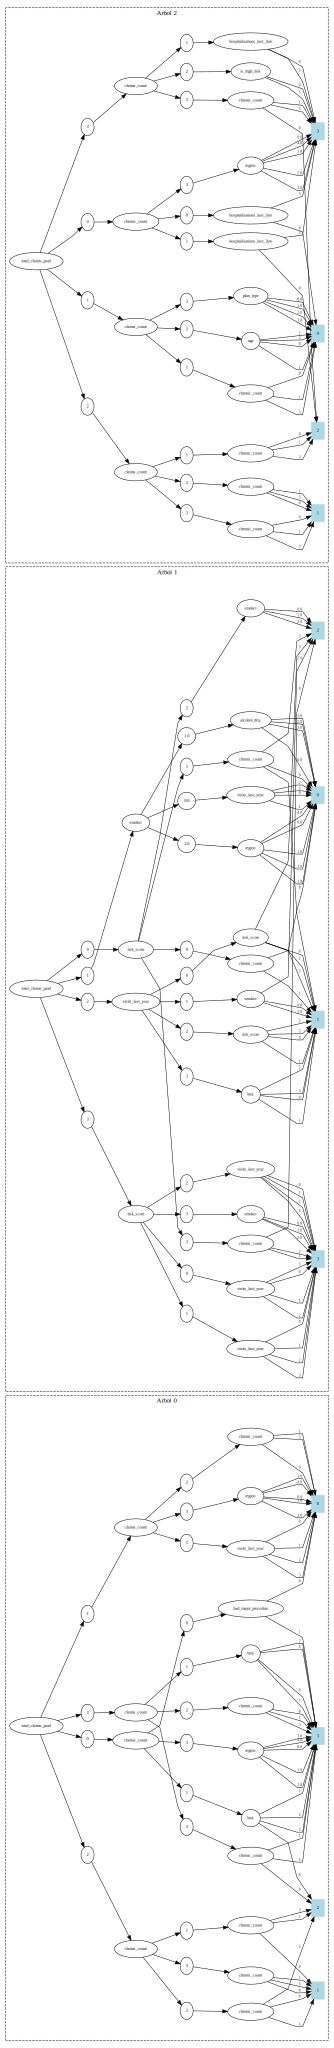

In [26]:
from graphviz import Digraph
from IPython.display import SVG, display

def graficar_bosque(bosque, max_arboles=3, escala=0.5):
    bosque_dot = Digraph(comment='Random Forest', graph_attr={'rankdir': 'LR', 'splines': 'polyline'})

    for idx, arbol in enumerate(bosque[:max_arboles]):
        with bosque_dot.subgraph(name=f'cluster_{idx}') as c:
            c.attr(label=f'Arbol {idx}', style='dashed')

            def agregar_nodos(subtree, parent=None, edge_label=''):
                for k, v in subtree.items():
                    nodo_id = f"{id(v)}_{idx}"
                    if isinstance(v, dict):
                        c.node(nodo_id, str(k), fontsize=str(int(12*escala)), width=str(0.5*escala))
                        if parent:
                            c.edge(parent, nodo_id, label=str(edge_label), fontsize=str(int(10*escala)))
                        agregar_nodos(v, nodo_id)
                    else:
                        hoja_id = f"{id(v)}_leaf_{idx}"
                        c.node(hoja_id, str(v), shape='box', style='filled', color='lightblue',
                               fontsize=str(int(12*escala)), width=str(0.5*escala))
                        c.edge(parent, hoja_id, label=str(k), fontsize=str(int(10*escala)))

            agregar_nodos(arbol)

    display(SVG(bosque_dot.pipe(format='svg')))

graficar_bosque(random_forest, max_arboles=3, escala=0.75)

#Random Forest Classifier

In [27]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

atributos = atributos = df.columns[:-1]
clase_col = df_train.columns[-1]   # última columna como target

# Convertir los atributos en un vector
assembler = VectorAssembler(inputCols=atributos, outputCol="features")

# Si tu variable objetivo es categórica, también debes convertirla a índice
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol=clase_col, outputCol="label")

In [28]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import RandomForestRegressor

modelo = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=5, maxDepth=5, seed=1234)

pipeline = Pipeline(stages=[assembler, indexer, modelo])
modelo_entrenado = pipeline.fit(df_train)

df_pred = modelo_entrenado.transform(df_test)
df_pred.select(atributos + ["label", "prediction"]).show(10)

+------------+--------+----+--------------+--------------+------------+-------------------+------+------+------------+---------+------------+---+------+---+-------------+-----+----------+----------------+--------------------------+----------------+------------------+------------------+----------+--------------+------------+-----------------+-----+----------+
|hypertension|diabetes|copd|cancer_history|kidney_disease|is_high_risk|had_major_procedure|region|smoker|alcohol_freq|plan_type|network_tier|age|income|bmi|chronic_count|hba1c|risk_score|visits_last_year|hospitalizations_last_3yrs|medication_count|proc_imaging_count|proc_surgery_count|deductible|annual_premium|claims_count|total_claims_paid|label|prediction|
+------------+--------+----+--------------+--------------+------------+-------------------+------+------+------------+---------+------------+---+------+---+-------------+-----+----------+----------------+--------------------------+----------------+------------------+-----------

In [29]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(df_pred)
print("Exactitud:", accuracy)

Exactitud: 0.7346938775510204
